In [2]:
import os, random, time, copy, math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

import torch.optim as optim
import torch.nn as nn
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

print('PyTorch', torch.__version__)

PyTorch 2.6.0+cpu


In [3]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

DATA_ROOT = Path('100x100_dataset')
TRAIN_DIR = DATA_ROOT / 'train'
VAL_DIR   = DATA_ROOT / 'val'
TEST_DIR  = DATA_ROOT / 'test'

IMG_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds = datasets.ImageFolder(VAL_DIR, transform=test_transforms)
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

n_classes = len(train_ds.classes)
print('Number of classes:', n_classes)

Number of classes: 82


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
model = SimpleCNN(n_classes).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18432, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=82, bias=True)
  )
)

In [6]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    running_loss, running_correct = 0, 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == y).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, loss_fn):
    model.eval()
    running_loss, running_correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            running_loss += loss.item() * X.size(0)
            _, preds = outputs.max(1)
            running_correct += (preds == y).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_correct / len(loader.dataset)
    return epoch_loss, epoch_acc

In [7]:
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train: loss {train_loss:.5f}, acc {train_acc:.5f} | "
          f"Val: loss {val_loss:.5f}, acc {val_acc:.5f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    total_time = time.time() - start_time
    print(f'Training completed in {total_time/60:.1f}min')
    model.load_state_dict(best_model_wts)
    

Epoch 1/20 | Train: loss 0.82571, acc 0.77035 | Val: loss 0.07782, acc 0.97564
Training completed in 6.2min
Epoch 2/20 | Train: loss 0.15254, acc 0.95087 | Val: loss 0.04851, acc 0.98347
Training completed in 11.8min
Epoch 3/20 | Train: loss 0.09244, acc 0.96994 | Val: loss 0.00904, acc 0.99724
Training completed in 17.2min
Epoch 4/20 | Train: loss 0.08586, acc 0.97310 | Val: loss 0.00323, acc 0.99956
Training completed in 22.8min
Epoch 5/20 | Train: loss 0.05925, acc 0.98206 | Val: loss 0.01828, acc 0.99275
Training completed in 28.1min
Epoch 6/20 | Train: loss 0.07253, acc 0.97811 | Val: loss 0.00439, acc 0.99884
Training completed in 33.5min
Epoch 7/20 | Train: loss 0.07209, acc 0.97774 | Val: loss 0.00461, acc 0.99840
Training completed in 38.5min
Epoch 8/20 | Train: loss 0.07191, acc 0.97767 | Val: loss 0.00663, acc 0.99797
Training completed in 43.3min
Epoch 9/20 | Train: loss 0.07181, acc 0.97792 | Val: loss 0.00315, acc 0.99913
Training completed in 47.8min
Epoch 10/20 | Train:

In [8]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn)
print(f'Test acc: {test_acc:.5f}, Test loss: {test_loss:.5f}')

Test acc: 0.99942, Test loss: 0.00807


In [9]:
MODEL_PATH = 'simple_fruit_cnn_1.pth'
torch.save(model.state_dict(), MODEL_PATH)
print('Model saved in', MODEL_PATH)

Model saved in simple_fruit_cnn_1.pth


                  precision    recall  f1-score   support

           Apple       1.00      1.00      1.00       242
         Apricot       1.00      1.00      1.00        99
         Avocado       1.00      1.00      1.00        99
          Banana       1.00      0.99      1.00       171
           Beans       1.00      1.00      1.00        12
        Beetroot       1.00      1.00      1.00        23
      Blackberry       0.98      1.00      0.99       102
       Blueberry       1.00      1.00      1.00        93
         Cabbage       1.00      1.00      1.00        29
          Cactus       1.00      1.00      1.00       134
      Cantaloupe       1.00      1.00      1.00        38
       Carambula       1.00      1.00      1.00        36
          Carrot       1.00      1.00      1.00        23
     Cauliflower       1.00      1.00      1.00       141
          Cherry       1.00      1.00      1.00       161
        Chestnut       1.00      1.00      1.00        91
      Clement

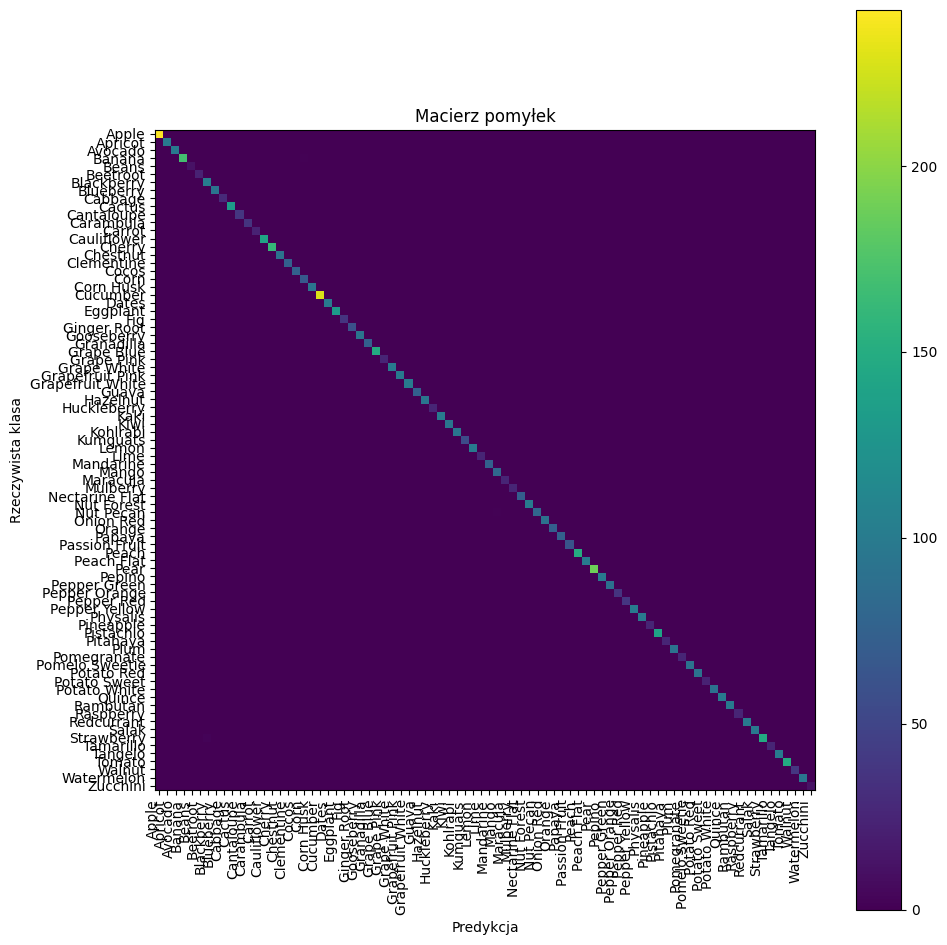

In [10]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        preds = model(X).argmax(1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)
        
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(test_ds.classes)),
    yticks=np.arange(len(test_ds.classes)),
    xticklabels=test_ds.classes,
    yticklabels=test_ds.classes,
    xlabel='Predykcja', ylabel='Rzeczywista klasa'
)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_ylim(len(test_ds.classes)-0.5, -0.5)  # fix bug
plt.title('Macierz pomyłek')
plt.tight_layout()
plt.show()